# BagiData Data Scientist Test
## Spam Comment Classification
Submitted by Nikko P. Gunara

February 25th, 2022.

 #### Summary
In general, the framework or the flowchart of Spam Comment Classification is similar to the News Title Classification which includes Preprocessing, Feature Extraction, Dimensionality Reduction, Classification & Optimization, and Evaluation. 

Amongst the models used, in this Spam Comment Classification, SVM shows the best performance on the test data with the highest Accuracy and F1 score of up to 0.91 and 0.91, respectively. The test data consists of 20% of the dataset with an amount of 256 data. This result may due to the nature of SVM that is known to be works well for binary classification.

But there are a few differences due to the different cases and datasets as listed below:
 #### 1. Dataset balance.

The class of Spam and Not spam in this dataset seems to be balanced, with a ~2% only difference.

 #### 2. Feature extraction.

For this Spam Comment Classification case, a pre-trained word embedding model is also used for feature extraction, but in a different model. The model used is 'glove-twitter-200' which is also from Gensim library that has been trained using about 2 billion tweets. The use of this model is due to the similarity of comments and tweets in general.

 #### 3. Cross-validation.

Since the data is seems to be balanced for each class, cross-validation for this case is not using stratified one, but using a standard k-fold cross-validation.
    
 #### 4. Performance metric.

For News Title Classification case with imbalanced dataset, the use of F1 score is appropriate to measure and evaluate the performance of the models. While in this case, with a balanced dataset, we can use simple accuracy score to measure and evaluate the models.

## Importing Libraries and Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import joblib
tqdm.pandas()
import re
import string
from autocorrect import Speller
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_excel('Comment Spam.xls', index_col='No')
comments = df['Comment']
labels = df['Class']
df.head()

,Comment,Class
No,,
1,this song is racist,0
2,and how many subscribers compared to her over ...,1
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
4,well done shakira,0
5,:D subscribe to me for daily vines,1


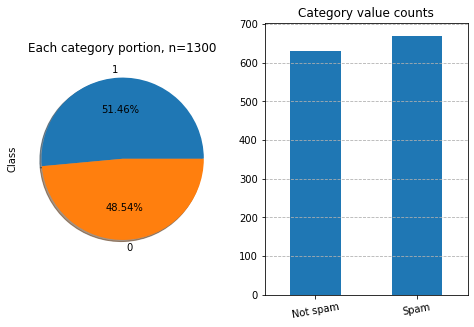

In [5]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
labels.value_counts().plot(kind='pie', autopct='%.2f%%', shadow=True, ax=ax[0])
ax[0].set_title(f'Each category portion, n={len(df)}')
labels.value_counts().sort_values().plot(kind='bar', ax=ax[1])
ax[1].set_title('Category value counts')
ax[1].yaxis.grid(linestyle='--')
ax[1].set_xticklabels(['Not spam', 'Spam'], rotation=10)
plt.show()

## Preprocessing

In [6]:
comments = comments.progress_apply(lambda x: x.lower())

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 35134.29it/s]


In [7]:
def clean_text(text):
    rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''},  # remove spaces at the beginning
        {r'[0-9]+': ''}, # remove numbers
        {r'(http\S+|\S+.com|\S+.net)': ''} # removing url link
    ]
    for rule in rules:
        for k, v in rule.items():
            regex = re.compile(k)
            text = regex.sub(v, str(text))
            text = text.strip()
            text = text.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuations
    return text

comments = comments.progress_apply(lambda comment: clean_text(comment))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 6074.31it/s]


In [8]:
comments = comments.progress_apply(lambda comment: word_tokenize(comment))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 6279.74it/s]


In [9]:
stopwords_ = set(stopwords.words('english'))
comments = comments.progress_apply(lambda comment: [w for w in comment if not w in stopwords_])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 216141.25it/s]


In [10]:
spell = Speller(lang='en')
comments = comments.progress_apply(lambda comment: [spell(w) for w in comment])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [02:23<00:00,  9.07it/s]


In [11]:
lemmatizer = WordNetLemmatizer()
comments = comments.progress_apply(lambda comment: [lemmatizer.lemmatize(w) for w in comment])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:01<00:00, 713.71it/s]


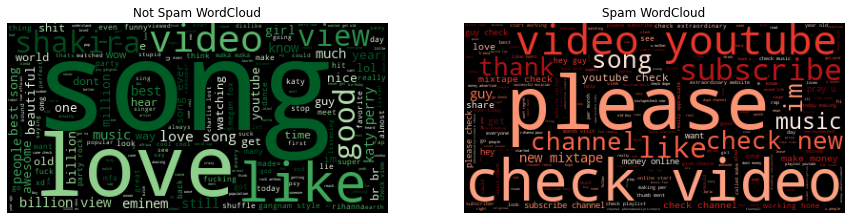

In [12]:
notSpamText = ''
spamText = ''

for comment, label in zip(comments, labels):
    if label==0:
        for word in comment:
            notSpamText += ' ' + word
    elif label==1:
        for word in comment:
            spamText += ' ' + word
        
notSpamWC = WordCloud(background_color='black',
            min_font_size=3, colormap='Greens',
            stopwords=stopwords_).generate(notSpamText)
spamWC = WordCloud(background_color='black',
        min_font_size=3, colormap='Reds',
        stopwords=stopwords_).generate(spamText)

fig, ax = plt.subplots(1,2, figsize=(15,9))
ax[0].set_title('Not Spam WordCloud')
ax[0].imshow(notSpamWC)
ax[0].axis('off')
ax[1].set_title('Spam WordCloud')
ax[1].imshow(spamWC)
ax[1].axis('off')
plt.show()

In [ ]:
glove_twitter = api.load('glove-twitter-200')

In [13]:
fname = "glove-twitter-200.bin"

# glove_twitter.save(fname)
glove_twitter = KeyedVectors.load(fname)

In [14]:
def glove_func(word):
    try:
        return glove_twitter[word]
    except:
        return [float(0) for i in range(200)]

vecs = comments.progress_apply(lambda comment: np.array([glove_func(w) for w in comment]).mean(axis=0))

  0%|                                                                                                            | 0/1300 [00:00<?, ?it/s]C:\Users\Nikko Prayudi\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 9418.48it/s]


In [15]:
vecsDF = pd.DataFrame.from_dict(dict(zip(vecs.index, vecs.values))).T
vecsDF['labels'] = labels
vecsDF = vecsDF.dropna()
vecsDF.reset_index(drop=True, inplace=True)
vecsDF.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,labels
0,-0.009825,0.184265,0.035115,0.287945,-0.012820,0.168015,0.718840,-0.198750,0.125185,-0.273170,...,-0.064882,0.130029,-0.004843,0.164452,0.157024,0.056628,0.547030,-0.342939,-0.071849,0
1,0.540093,-0.180121,-0.043433,0.534503,-0.025710,-0.061383,0.291183,0.285613,-0.170330,0.018850,...,-0.036515,0.171197,-0.138658,0.283320,-0.034495,0.028860,0.580800,0.233643,-0.256187,1
2,-0.049478,0.302784,-0.235649,-0.162385,-0.270928,0.070178,0.555570,0.038048,0.075661,-0.093803,...,0.062539,0.121959,-0.108869,-0.352026,-0.132150,-0.112996,0.118559,0.084431,-0.054003,1
3,-0.020967,0.009285,-0.018198,0.329427,-0.317501,0.083597,0.503873,0.218786,0.105163,0.008889,...,-0.157409,0.347357,0.363573,0.154467,-0.454295,0.435993,-0.049614,-0.024523,0.040046,0
4,-0.209317,0.433977,-0.221940,-0.368127,-0.191903,-0.680287,0.754160,-0.146473,0.307228,-0.065083,...,-0.491632,0.357268,-0.163757,0.124597,0.585550,-0.110186,0.142925,0.273140,-0.099626,1


In [17]:
filename = "spamcomment-extracted-checkpoint.pkl"

# saving ready-to-use vector dataframe to file
vecsDF.to_pickle(filename)

# load saved file
# vecsDF = pd.read_pickle(filename)

## Dimensionality Reduction

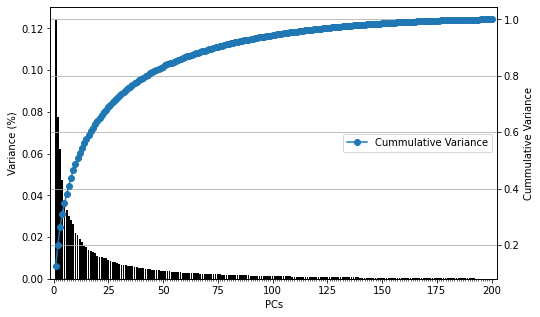

In [18]:
ss = StandardScaler()
Xstd = ss.fit_transform(vecsDF.iloc[:,:-1])

pca = PCA()
Xpca = pca.fit_transform(Xstd)

features = range(1, pca.n_components_+1)
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(features, pca.explained_variance_ratio_, color='black', label='Variance (%)')
ax1.set_xlabel('PCs')
ax1.set_ylabel('Variance (%)')
ax1.set_xticks([i+1 for i in range(len(pca.explained_variance_))], minor=True)
ax1.margins(x=0.01)

ax2 = ax1.twinx()
ax2.plot([i+1 for i in range(len(pca.explained_variance_ratio_))], np.cumsum(pca.explained_variance_ratio_), '-o', label='Cummulative Variance')
ax2.set_ylabel('Cummulative Variance')
plt.grid()
plt.legend(loc=7)
plt.show()

In [24]:
dfPCA = pd.DataFrame(Xpca)
dfPCA['labels'] = vecsDF.labels.apply(lambda label: "Spam" if label==1 else "Not spam")
dfPCA.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,labels
0,-2.887022,6.840294,-0.534849,6.780631,-7.833707,0.273983,1.497692,3.812743,4.187636,3.377492,...,0.299241,-0.249941,-0.184913,-0.129156,-0.199266,0.101009,-0.147436,-0.395012,0.058110,Not spam
1,-3.624062,-6.459776,-3.454338,1.717794,3.059479,4.102852,7.667701,5.203716,1.157409,3.227600,...,0.058490,0.107069,-0.543256,0.127282,-0.035511,0.130254,-0.244701,-0.304327,0.053123,Spam
2,1.628925,0.861721,2.154279,-3.075745,-0.598024,-3.129768,-0.003358,-0.431117,4.247554,0.784535,...,0.030437,-0.126893,-0.034691,-0.119016,-0.047242,-0.051269,-0.027334,-0.049739,-0.076991,Spam
3,-4.185540,2.525428,-0.402829,3.579429,1.074398,-4.829184,3.900112,-2.787996,2.489634,-6.573294,...,0.188783,0.371611,-0.381121,0.027869,-0.109496,0.133406,0.128610,0.041436,-0.012769,Not spam
4,10.871437,-4.495667,7.036220,2.754583,-1.740595,1.412194,4.561801,0.425197,-5.424615,-1.318593,...,-0.069407,-0.005238,-0.220576,0.025531,-0.018694,0.196748,0.006601,-0.086566,-0.013561,Spam


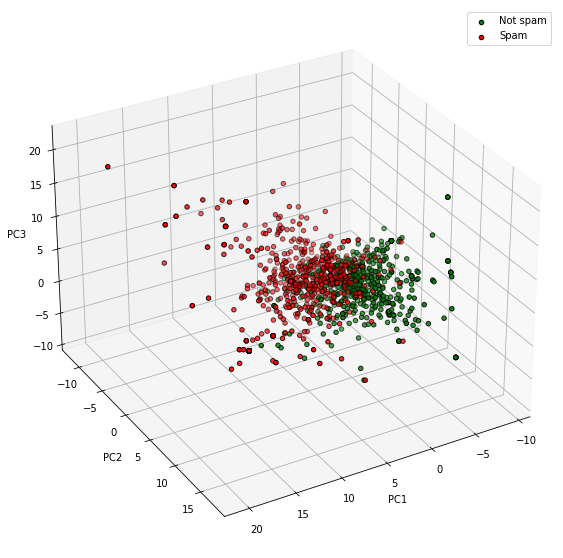

In [25]:
pcx = 'PC1'
pcy = 'PC2'
pcz = 'PC3'
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
colors = ['green', 'red']

for color, label in zip(colors, ['Not spam', 'Spam']):
    ax.scatter3D(dfPCA[dfPCA['labels']==label][0], dfPCA[dfPCA['labels']==label][1], dfPCA[dfPCA['labels']==label][2], color=color, marker='o', edgecolors='k', label=label)

ax.set_xlabel(pcx)
ax.set_ylabel(pcy)
ax.set_zlabel(pcz)
ax.view_init(elev=30., azim=60.) # rotate view angle
plt.legend()
plt.show()

## Train and Tune Models

In [26]:
X = vecsDF.iloc[:,:-1]
y = vecsDF.labels

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=23)

### k-Nearest Neighbors

In [33]:
pipeKNN = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', KNeighborsClassifier(algorithm='kd_tree')) # using kd_tree because memory error
])

In [34]:
parameter_grid = {
    'pca__n_components': list(np.linspace(1,100,100, dtype=int)),
    'clf__n_neighbors': list(np.linspace(1,20,20, dtype=int))
}

bsKNN = BayesSearchCV(
    pipeKNN,
    parameter_grid,
    scoring='accuracy',
    verbose=10,
    n_jobs=4,
    cv=10,
    n_iter=50
)

print("[INFO]: Tuning started.")
bsKNN.fit(x_train, y_train)
print("[INFO]: Done.")
print(f"\nBEST PARAMETERS: ")
for k,v in zip(bsKNN.best_params_.keys(), bsKNN.best_params_.values()):
    print(f'{k}\t: {v}')

[INFO]: Tuning started.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


D:\PythonThings\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [46]:
model_filename = 'spamcomment-bayes-knn.pkl'

# save best estimator to disk
# joblib.dump(bsKNN.best_estimator_, model_filename)

# load saved model from disk
bsKNN = joblib.load(model_filename)

[INFO]: Classification Reports:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       126
           1       0.91      0.89      0.90       130

    accuracy                           0.90       256
   macro avg       0.90      0.90      0.90       256
weighted avg       0.90      0.90      0.90       256



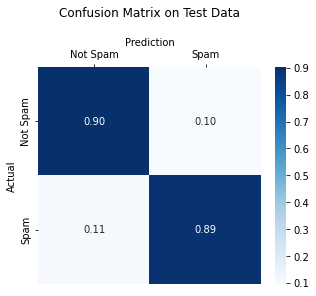

In [35]:
y_pred = bsKNN.predict(x_test)
print("[INFO]: Classification Reports:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Not Spam', 'Spam'])
ax.set_yticklabels(['Not Spam', 'Spam'])
plt.show()

### XGBoost

In [36]:
pipeXGB = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', XGBClassifier(n_jobs=-1,
                          eval_metric='logloss',
                          use_label_encoder=False))
])

In [37]:
parameter_grid = {
    'pca__n_components': list(np.linspace(1,50,50, dtype=int)),
    'clf__n_estimators': list(np.linspace(10,50,41, dtype=int)),
    'clf__max_depth': list(np.linspace(5,50,46, dtype=int)),
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

bsXGB = BayesSearchCV(
    pipeXGB,
    parameter_grid,
    scoring='accuracy',
    verbose=1,
    cv=10,
    n_iter=50,
    random_state=22
)

print("[INFO]: Tuning started.")
bsXGB.fit(x_train, y_train)
print("[INFO]: Done.")
print(f"\nBEST PARAMETERS: ")
for k,v in zip(bsXGB.best_params_.keys(), bsXGB.best_params_.values()):
    print(f'{k}\t: {v}')

[INFO]: Tuning started.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [47]:
model_filename = 'spamcomment-bayes-xgb.pkl'

# save best estimator to disk
# joblib.dump(bsXGB.best_estimator_, model_filename)

# load saved model from disk
bsXGB = joblib.load(model_filename)

[INFO]: Classification Reports:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       126
           1       0.93      0.87      0.90       130

    accuracy                           0.90       256
   macro avg       0.90      0.90      0.90       256
weighted avg       0.90      0.90      0.90       256



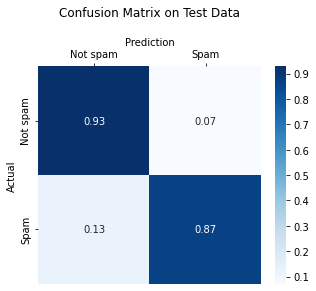

In [38]:
y_pred = bsXGB.predict(x_test)
print("[INFO]: Classification Reports:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Not spam', 'Spam'])
ax.set_yticklabels(['Not spam', 'Spam'])
plt.show()

### Support Vector Machine

In [39]:
pipeSVM = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', SVC(random_state=13, probability=True))
])

In [40]:
parameter_grid = {
    'pca__n_components': list(np.linspace(1,50,50, dtype=int)),
    'clf__C': list(np.linspace(0.1,100,100, dtype=float)),
    'clf__kernel': ['rbf', 'poly', 'sigmoid']
}

bsSVM = BayesSearchCV(
    pipeSVM,
    parameter_grid,
    scoring='accuracy',
    verbose=1,
    cv=10,
    n_iter=50,
    random_state=22
)

print("[INFO]: Tuning started.")
bsSVM.fit(x_train, y_train)
print("[INFO]: Done.")
print(f"\nBEST PARAMETERS: ")
for k,v in zip(bsSVM.best_params_.keys(), bsSVM.best_params_.values()):
    print(f'{k}\t: {v}')

[INFO]: Tuning started.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [48]:
model_filename = 'spamcomment-bayes-svm.pkl'

# save best estimator to disk
# joblib.dump(bsSVM.best_estimator_, model_filename)

# load saved model from disk
bsSVM = joblib.load(model_filename)

[INFO]: Classification Reports:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       126
           1       0.92      0.91      0.91       130

    accuracy                           0.91       256
   macro avg       0.91      0.91      0.91       256
weighted avg       0.91      0.91      0.91       256



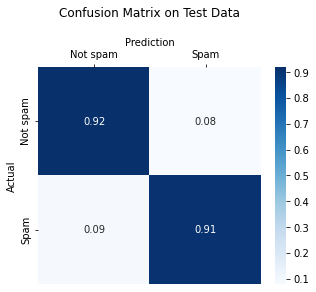

In [42]:
y_pred = bsSVM.predict(x_test)
print("[INFO]: Classification Reports:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Not spam', 'Spam'])
ax.set_yticklabels(['Not spam', 'Spam'])
plt.show()

## Evaluation

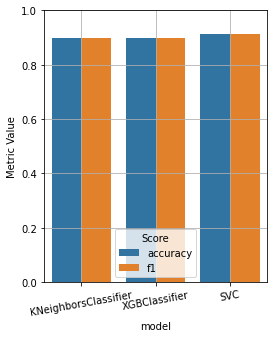

In [49]:
accuracies, f1s, models = list(), list(), list()

for model in [bsKNN, bsXGB, bsSVM]:
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracies.append(acc)
    f1s.append(f1)
    models.append(str(model.steps[2][1]).split('(')[0])

df_plot = pd.DataFrame(zip(accuracies, f1s, models), columns=['accuracy', 'f1', 'model'])
df_melt = pd.melt(df_plot, id_vars='model', var_name='Score', value_name='Metric Value')
fig, ax = plt.subplots(figsize=(4,5))
g = sns.barplot(x='model', y='Metric Value', hue='Score', data=df_melt, ax=ax)
g.set(ylim=(0, 1))
plt.xticks(rotation=10)
plt.grid()
plt.show()

Amongst the models used, in this Spam Comment Classification, SVM shows the best performance on the test data with the highest Accuracy and F1 score of up to 0.91 and 0.91, respectively. The test data consists of 20% of the dataset with an amount of 256 data. This result may due to the nature of SVM that is known to be works well for binary classification.

### Arbitrary input Test

In [ ]:
def preprocess_text(comments):
    comments = pd.Series(comments)
    comments = comments.apply(lambda x: x.lower())
    comments = comments.apply(lambda comment: clean_text(comment))
    comments = comments.apply(lambda comment: word_tokenize(comment))
    comments = comments.apply(lambda comment: [w for w in comment if not w in stopwords_])
    comments = comments.apply(lambda comment: [spell(w) for w in comment])
    comments = comments.apply(lambda comment: [lemmatizer.lemmatize(w) for w in comment])
    vector = comments.apply(lambda comment: np.array([glove_func(w) for w in comment]).mean(axis=0))
    return vector

In [ ]:
test_comment = input('> ')

vector = preprocess_text(test_comment)
prediction = bsSVM.predict(vector.values[0].reshape(1,-1))
print(f"Prediction: {['Spam' if p==1 else 'Not spam' for p in prediction]}")